<br/><br/>
<h1 align="center">Finding Relevant Information in Big Datasets with ML</h1> 
<br/><br/>
<h3 align="center">Authors:</h3> 
<h3 align="center">Uchechukwu Njoku, Alberto Abelló, Besim Bilalli, Gianluca Bontempi</h3> 
<h4 align="center">EDBT 2024</h4> 
<h4 align="center">Paestum, Italy</h4> 
<h4 align="center">27<sup>th</sup> March, 2024</h4> 

In [1]:
# Import all required libraries
import time
import random
import logging
import graphviz
import numpy as np
import pandas as pd
import openml as oml 
from sklearn import svm
from pathlib import Path
from sklearn import tree
from tabulate import tabulate
from matplotlib import pyplot as plt
from sklearn.naive_bayes import GaussianNB
from jmetal.core.problem import BinaryProblem
from jmetal.core.solution import BinarySolution
from IPython.display import IFrame, display, HTML
from sklearn.ensemble import RandomForestClassifier
from fairlearn.metrics import demographic_parity_ratio
from jmetal.algorithm.multiobjective.nsgaii import NSGAII
from traitlets.config.manager import BaseJSONConfigManager
from skfeature.function.statistical_based import gini_index
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.algorithm.singleobjective.genetic_algorithm import GeneticAlgorithm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from jmetal.util.termination_criterion import StoppingByEvaluations, StoppingByTime
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from jmetal.operator import SBXCrossover, PolynomialMutation, SPXCrossover, BitFlipMutation
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS, SequentialFeatureSelector as SFS

## Notebook on GitHub

<center>   
<img src="./images/qr-code.png" alt="transition" width="450" height="250">
</center>

### URL: https://github.com/F-U-Njoku/fs_tutorial

## Content:

1. Introduction to Feature Selection (FS)
2. **Search strategies**
3. **FS classes**
4. **Evaluation metrics**
5. Open challenges
6. Conclusion
7. Libraries

## Where we are: Data abundance

- Advancing in Storage and Processing <br/><br/>
    - Decreasing Storage Costs <br/><br/>
- Increasing Data Generation <br/><br/>
    - Data Variety <br/><br/>
- Seeking business Value <br/><br/>
    - Ethical consideracions

<center>
<img src="./images/bigdata.gif" alt="Big data" width="757" height="770"/>
<center/>

In [3]:

# Define the URL for the iframe
url = "https://wall.sli.do/event/wT2yM4CDVA39n1XggtSeNg?section=769d6d7d-76ba-48da-9cad-c72b102daa84"
# Create the IFrame
iframe = IFrame(url, width=600, height=800)
# Define HTML/CSS to center the iframe
slido1 = """
<div style="display: flex; justify-content: center;">
    {}
</div>
""".format(iframe._repr_html_())

# Join at slido.com 
# #2198 009
<center>   
<img src="./images/slido1.png" alt="transition" width="600" height="450">
</center>

In [4]:
# Display Slido poll results
display(HTML(slido1))

## High Dimensionality Challenges (Curse of Dimensionality)

<img src="./images/difficulties.png" alt="challenges" align="right" width="450" height="600"/>


- Long processing time

    - Storage and computational cost

- Difficulty in data and model understanding

    - Feature redundancy

    - Feature irrelevance

        - Spurious correlations
        
            - Storks population and natality in EU



## Necessary transition
<center>   
<img src="./images/Experimental Design1.png" alt="transition" width="1458" height="727">
</center>

## Necessary transition
<center>   
<img src="./images/Experimental Design2.png" alt="transition" width="1458" height="727">
</center>

## Feature selection (FS)
**Identification and selection of a subset of relevant features** (a.k.a., attributes, variables) in a dataset that accurately describe a given problem according to our requirements.
<center>   
<img src="./images/fs.png" alt="transition" width="1181" height="299">
</center>

**Benefits of FS include reducing:**  
- dimensionality
- overfitting
- training time & cost

**Benefits of FS include improving:** 
- model performance
- model interpretability/explainability 
- data understanding

## Feature selection (FS)
<center>   
<img src="./images/featureselection.png" alt="transition" width="1440" height="810">
</center>

## Running example
**German Credit dataset** classifies people, described by a set of attributes, into having high or low credit risk.

In [10]:
# Uncomment to install
#!pip install openml


  
# function to retrieve data    
def fetch_data(number):
    dataset = oml.datasets.get_dataset(number, download_data=True, 
                                       download_qualities=True, 
                                       download_features_meta_data=True)
    X, y, attribute_names, categorical_indicator,  = dataset.get_data(
        dataset_format="dataframe",
        target=dataset.default_target_attribute)
    return X, y, attribute_names, len(attribute_names)

# fetch dataset 
data, y, attribute_names, z = fetch_data(43808)

In [11]:
data.head()

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


In [12]:
# Rename columns
data.rename(columns={'laufkont':"checking_status", 
                  'laufzeit':"duration", 
                  'moral':"credit_history", 
                  'verw':"purpose", 
                  'hoehe':"credit_amount", 
                  'sparkont':"savings_status", 
                  'beszeit':"employment",
                  'rate':"installment_commitment", 
                  'famges':"personal_status", 
                  'buerge':"other_parties",
                  'wohnzeit':"residence_since", 
                  'verm':"property_magnitude", 
                  'alter':"age", 
                  'weitkred':"other_payment_plans",
                  'wohn':"housing", 
                  'bishkred':"existing_credits", 
                  'beruf':"job", 
                  'pers':"num_dependents", 
                  'telef':"own_telephone", 
                  'gastarb':"foreign_worker",
                  'kredit':"credit"}, inplace=True)

In [13]:
data.sample(3)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,credit
249,4,21,2,1,5248,5,3,1,3,1,...,3,26,3,2,1,3,2,1,2,1
114,2,21,2,2,3976,5,4,2,3,1,...,3,35,3,2,1,3,2,2,2,1
591,1,8,4,10,1164,1,5,3,3,1,...,4,51,1,3,2,4,1,2,2,1


Size:
- 21 features (20+1)
    * 1,048,574 possible solutions
- 1,000 instances

Characteristics:
- Target: credit
- Sensitive: personal_status

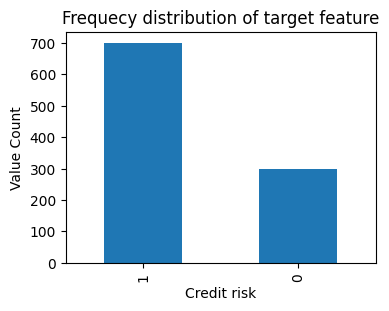

In [5]:
plot = data['credit'].value_counts().plot(kind='bar', title="Frequecy distribution of target feature", xlabel="Credit risk", ylabel="Value Count", figsize=(4,3))

In [17]:
# Display data
X = data.drop(["credit"], axis=1)
y = data["credit"]

In [18]:
# Predictors
X.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,1,18,4,2,1049,1,2,4,2,1,4,2,21,3,1,1,3,2,1,2
1,1,9,4,0,2799,1,3,2,3,1,2,1,36,3,1,2,3,1,1,2
2,2,12,2,9,841,2,4,2,2,1,4,1,23,3,1,1,2,2,1,2
3,1,12,4,0,2122,1,3,3,3,1,2,1,39,3,1,2,2,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,4,2,38,1,2,2,2,2,1,1


In [19]:
# Target
y.sample(5)

456    1
86     1
6      1
634    1
535    1
Name: credit, dtype: uint8

### Classifier 

In [32]:
# Naive Bayes Classifier
nb = GaussianNB()

### Predictive performance metrics
- Accuracy
- Precision
- Recall
- Specificity
- F1 score
- **Area Under Receiver Operating Characteristic Curve**

**ROC AUC**
<br></br>
<center>   
<img src="./images/AUC.svg" alt="transition" width="470.25" height="405.75">
</center>

Preferable for unbalanced data.

## Baseline: Full Dataset
<center>   
<img src="./images/gif3.png" alt="transition" width="374" height="386">
</center>

In [25]:
%%time
# Build classifier with all features
baseline = cross_val_score(estimator=nb, X=X, y=y, scoring="roc_auc", cv=2).mean()

print('AUC score with full dataset: %.2f%%' %(baseline*100))

AUC score with full dataset: 72.21%
CPU times: user 38.9 ms, sys: 0 ns, total: 38.9 ms
Wall time: 43.8 ms


## Content:
1. Introduction to Feature Selection (FS)
2. **Search strategies**
    * Exponential
    * Sequential
    * Heuristics-based <BR/><BR/>
3. **FS classes**
4. **Evaluation metrics**
5. Open challenges
6. Conclusion
7. Libraries

## Exponential search
Systematically explore an increasing number of subsets which grows exponentially with the size of the feature space.
<br><br/>

- Traverses (mostly) the entire search space
- Can guarantee the best solution
- Computationally prohibitively expensive
    - Feasible only for (very) small datasets

E.g: Exhaustive search, Branch-and-bound

<center>
<img src="./images/exhaustive.png" alt="exaustive search" width="528" height="338">
<center/>

### Applying Exhaustive search

In [33]:
%%time
# Exhaustive search
efs1 = EFS(nb, 
           min_features=1,
           max_features=20,
           scoring='roc_auc',
           print_progress=False,
           cv=2)

# Estimated execution time is 1 hour.
efs1 = efs1.fit(X, y.values.ravel())
print('Best AUC score: %.2f%%' % (efs1.best_score_*100))
print('Number of features:', len(efs1.best_idx_))

Best AUC score: 77.75%
Number of features: 9
CPU times: user 1h 10min 29s, sys: 2.62 s, total: 1h 10min 32s
Wall time: 1h 10min 32s



### Brand-and-bound
- Structures the search space as a tree
    - The root represents the set of all features
    - The intermediate child nodes contain a feature subset one smaller than its parent
- Top-down exploration with backtracking
    - Can be resticted to a predetermined minimum size for the feature subset


<center>
<img src="./images/bb.gif" alt="Big data" width="927" height="436"/>
<center/>

## Sequential search
Gradually shrink/enlarge the feature subset with features that improve (or maintain) the evaluation criterion.
<br/><br/>

- Simple
- Greedy algorithms
- Resilient against overfitting
- Best solution not guaranteed

E.g: Sequential Backward/Forward Selection

<center>
<img src="./images/sequential.png" alt="exaustive search" width="528" height="338">
 </center>

### Sequential Backward Selection
- n = 4
- Size = 2
- Starts with the whole set of features - {f1, f2, f3, f4}
<br/><br/>
<center>
<img src="./images/sbs.gif" alt="Big data" width="528" height="338"/>
<center/>

### Sequential Forward Selection
- n = 4
- Size = 2
- Starts with the empty set - {}
<br/><br/>
<center>
<img src="./images/sfs.gif" alt="Big data" width="528" height="338"/>
<center/>

### Sequential Forward Selection Algorithm

**Inputs:** 

    𝑀         //complete set of features
    𝑚𝑒𝑎𝑠𝑢𝑟𝑒() //evaluation criteria
    𝑘         //expected subset size

**Output:** 

    𝑆 //set of selected features

<center>
<img src="./images/sfs_algo.png" alt="fsf_algo" width="829" height="818"/>
<center/>

<code>
    1: 𝑆 ← {}
    2: 𝑠𝑐𝑜𝑟𝑒 ← 0
    3: do
        4: 𝑚𝑜𝑑𝑖𝑓𝑖𝑒𝑑 ← 𝑓𝑎𝑙𝑠𝑒
        5: for each 𝑓𝑒𝑎𝑡𝑢𝑟𝑒 ∈ 𝑀 do
            6: 𝑆<sub>𝑡𝑚𝑝</sub> ← (𝑆 ∪ {𝑓𝑒𝑎𝑡𝑢𝑟𝑒})
            7: 𝑚𝑒𝑡𝑟𝑖𝑐 ← 𝑚𝑒𝑎𝑠𝑢𝑟𝑒(𝑆<sub>𝑡𝑚𝑝</sub>)
            8: if (metric >= score) then
                9: 𝑚𝑜𝑑𝑖𝑓𝑖𝑒𝑑 ← 𝑡𝑟𝑢𝑒
                10: 𝑠𝑒𝑙𝑒𝑐𝑡𝑒𝑑 ← 𝑓𝑒𝑎𝑡𝑢𝑟𝑒
                11: 𝑠𝑐𝑜𝑟𝑒 ← 𝑚𝑒𝑡𝑟𝑖𝑐
        12: if modified then
            13: 𝑆 ← (𝑆 ∪ {𝑠𝑒𝑙𝑒𝑐𝑡𝑒𝑑})
            14: 𝑀 ← (𝑀 \ {𝑠𝑒𝑙𝑒𝑐𝑡𝑒𝑑})
    15: while (modified and (|S| < 𝑘))
    16: return 𝑆
</code> 

### Applying Sequential Forward Selection

In [68]:
%%time
# Sequential Foward Selection
sfs1 = SFS(nb, 
           k_features=9, 
           forward=True, 
           scoring='roc_auc',
           cv=2)

sfs1 = sfs1.fit(X, y)
print('Best AUC score: %.2f%%' % (sfs1.k_score_*100))

Best AUC score: 77.68%
CPU times: user 861 ms, sys: 2.76 ms, total: 864 ms
Wall time: 875 ms


## Heuristics-based search
Randomly explore the search space using heuristics to drive it and avoid local minima. 

- Wider exploration of the search space
- Heuristics imitate natural population evolution
- Can be trapped in local optimum

E.g: Particle swarm optimisation, genetic algorithms

<center>
<img src="./images/population-based.png"  alt="exaustive search"  width="528" height="338">
 </center>

### Genetic algorithm (GA)
GA entities:
- Chromosomes --> Subset of features
- Genes ------------> Features
- Alleles -----------> Selection indication (0 or 1)

Steps:
1. **Initialization:** initialize the population of candidate solutions
2. **Evaluation:** measure the fitness of each candidate solution
3. **Selection:** survival of the fittest to keep 'better' solutions
4. **Recombination:** crossover of the selected solutions to form new/better offspring
5. **Mutation:** local and random modification of every solution to add diversity
6. **Replacement:** replace (part of) current population with the created offspring
7. Repeat 2 - 6 until termination criterion is satisfied

In [71]:
class credit(BinaryProblem):
    
    def __init__(self, pred: pd.DataFrame, target: pd.Series, classifier, n_var:int=20):
        super(credit, self).__init__()
        self.pred = pred
        self.target = target
        self.classifier = classifier
        self.n_var = n_var
        self.obj_labels = ["auc"]
        
    def number_of_variables(self) -> int:
        return 1
    def number_of_objectives(self) -> int:
        return 1
    def number_of_constraints(self) -> int:
        return 1
        
    def evaluate(self, solution: BinarySolution) -> BinarySolution:
        
        # check constraint and if violated generate a new solution
        self.__evaluate_constraints(solution)
        if solution.constraints[0] == 0:
            check = random.randrange(self.n_var)
            solution.variables[0] = [True if _ == check else False for _ in range(self.n_var)]
       
        auc = cross_val_score(estimator=self.classifier, 
                                   X=self.pred.iloc[:,solution.variables[0]], y=self.target,
                                   scoring="roc_auc", cv=2).mean()
        solution.objectives[0] = auc * -1.0
        return solution
        
    def __evaluate_constraints(self, solution: BinarySolution) -> None:
        solution.constraints = [0 for _ in range(self.number_of_constraints())]
        if sum(solution.variables[0]) == 0:
            solution.constraints[0] = 0
        else:
            solution.constraints[0] = 1
        
    def create_solution(self) -> BinarySolution:
        new_solution = BinarySolution(number_of_variables=self.number_of_variables(),
                                      number_of_objectives=self.number_of_objectives())
        new_solution.variables[0] =  [True if random.randint(0, 1) == 1 else 
                                      False for _ in range(self.n_var)]
        return new_solution
    
    def name(self) -> str:
        return 'Credit'
logging.disable()

### Applying  Genetic Algorithm

In [72]:
%%time
# Genetic algorithm
problem = credit(X, y, nb)
algorithm = GeneticAlgorithm(
        problem=problem,
        population_size=40,
        offspring_population_size=40,
        mutation=BitFlipMutation(1.0 / problem.n_var),
        crossover=SPXCrossover(1.0),
        termination_criterion=StoppingByEvaluations(max_evaluations=20000),
    )
# Estimated execution time is 2 mins.
algorithm.run()
result = algorithm.get_result()
indices = [int(i) for i in range(len(result.get_binary_string())) if result.get_binary_string()[i] == "1"]

CPU times: user 3min 16s, sys: 0 ns, total: 3min 16s
Wall time: 3min 16s


In [74]:
print('Best AUC score: %.2f%%' % (result.objectives[0]*-100))
print('Number of features:', len(indices))

Best AUC score: 77.75%
Number of features: 9


## Summary
- In the context of big data, exponential search is infeasible.
- The outcome of exponential and sequential methods are deterministic.
    - Not so heuristic-based search.
- In general, feature selection may improve performance and model understanding.

<BR/><BR/>

|Measure | Baseline |Exponential  | Sequential    | Heuristics-based  
|---:|-------------|:-------------|:-----------|:------|
| AUC|72.21%| 77.75% % |    77.68%   |  77.75%  | 
| Size| 20|9 |    9    |   9 | 
| Time |43.8 ms| 1h 10min  | 875 ms    |  3 mins | 

## Any Questions/Comments
<br></br>
<center>   
<img src="./images/person.png" alt="transition" width="512" height="512">
</center>

## Content:
1. Introduction to Feature Selection (FS)
2. **Search strategies**
3. **FS classes**
    * Filter methods
    * Wrapper methods
    * Embeded methods
    * Hybrid methods <BR/><BR/>
4. **Evaluation metrics**
5. Open challenges
6. Conclusion
7. Libraries

In [5]:

# Define the URL for the iframe
url = "https://wall.sli.do/event/4x1hRrKH2aAagWbB3j4XA1?section=b8b6bb36-55a1-44f9-9680-2895646ddf65"
# Create the IFrame
iframe = IFrame(url, width=600, height=800)
# Define HTML/CSS to center the iframe
slido2 = """
<div style="display: flex; justify-content: center;">
    {}
</div>
""".format(iframe._repr_html_())

# Join at slido.com 
# #2256 105
<center>   
<img src="./images/slido2.png" alt="transition" width="450" height="250">
</center>

In [6]:
# Display Slido poll resutls
display(HTML(slido2))

## Filter methods
Evaluate and select features independent of any learning algorithm by solely relying on the characteristics of the dataset to determine the relevance of a feature.

<center>
<img src="./images/filter.png" align="left" alt="filter" width="528" height="338">
</center>

- Fast execution time
- Model independent
- Robust to overfitting
- Possible redundancy 
- Non ‘optimal’ selection

E.g: Gini, Mutual information, Correlation measures

**Similarity-Based Filter Methods**
- Laplacian Score
- Fisher Score
- Trace Ratio Criterion
- ReliefF

**Information-Theoretical-Based Filter Methods**
- Information Gain, Entropy
- Minimum Redundancy Maximum Relevance (MRMR)
- Joint Mutual Information
- Fast Correlation-Based Filter

**Sparse-Learning-Based Filter Methods**
- Feature Selection with Lp -Norm Regularizer.
- Efficient and Robust Feature Selection
- Feature Selection Using Nonnegative Spectral Analysis

**Statistical-Based Filter Methods**
- Low Variance
- T-Score
- Chi-Square Score
- Gini Index

### Related Work
<center>   
<img src="./images/title.png" alt="title" width="993" height="235">
</center>

<br></br>

- Eight Filter methods
- Four ML algorithms

#### Runtime
<center>   
<img src="./images/runtime.png" alt="runtime" width="649.5" height="525">
</center>

#### Proposed guidelines 
<center>   
<img src="./images/recommendation.png" alt="recommendation" width="1345" height="764">
</center>

### Gini index
A statistical-based measure used to assess whether a feature effectively distinguishes instances belonging to different classes. The lower the Gini index value, the more relevant the feature is.

### Applying  Gini Index

In [176]:
%%time
score = gini_index.gini_index(X.values, y.values)
# rank features in descending order according to score
idx = gini_index.feature_ranking(score)
sorted(zip(score, X.columns),key=lambda x: x[0])

CPU times: user 72.1 ms, sys: 3.6 ms, total: 75.7 ms
Wall time: 73.5 ms


[(0.3720903804538366, 'checking_status'),
 (0.40293787540546877, 'credit_history'),
 (0.4051935788479697, 'savings_status'),
 (0.4063784549964565, 'duration'),
 (0.4089123232700295, 'credit_amount'),
 (0.4131254061078622, 'age'),
 (0.41335850910319, 'property_magnitude'),
 (0.4141996384816228, 'employment'),
 (0.41460991783572415, 'other_payment_plans'),
 (0.4160563254558032, 'purpose'),
 (0.4161718750000001, 'personal_status'),
 (0.4163841615688729, 'housing'),
 (0.4171704414695068, 'foreign_worker'),
 (0.4178956315350567, 'installment_commitment'),
 (0.4187276858162934, 'other_parties'),
 (0.4191217807163672, 'existing_credits'),
 (0.41930909783022463, 'job'),
 (0.41944149112897866, 'own_telephone'),
 (0.4198408488063661, 'residence_since'),
 (0.4199961824775721, 'num_dependents')]

#### Top - 9

In [77]:
top_9 = ['checking_status','credit_history','savings_status', 'duration','credit_amount', 
'age','property_magnitude', 'employment', 'other_payment_plans']
auc = cross_val_score(estimator=nb,X=X.loc[:,top_9], y=y,
                scoring="roc_auc", cv=2).mean()
print('Filter --> AUC score with top 9 features: %.2f%%' %(auc*100))

Filter --> AUC score with top 9 features: 76.54%


## Wrapper methods
Depend on the performance metrics (e.g., accuracy or AUC) of a chosen Machine Learning (ML) algorithm to evaluate generated feature subsets.

<center>
<img src="./images/wrapper.png" alt="wrapper" width="650" height="409">
</center>

- Model dependent
- High accuracy 
- Captures dependencies
- Risk of overfitting
- Computationally intense

E.g: ML performance metrics

### Applying Wrapper with NB classifier using AUC metric

In [78]:
%%time
# Nine features
sfs1 = SFS(nb, 
           k_features=9, 
           forward=True, 
           scoring='roc_auc',
           cv=2)

sfs1 = sfs1.fit(X, y)
print('Wrapper --> AUC score with top 9 features: %.2f%%' % (sfs1.k_score_*100))

Wrapper --> AUC score with top 9 features: 77.68%
CPU times: user 856 ms, sys: 3.81 ms, total: 860 ms
Wall time: 865 ms


## Embedded methods
ML algorithms that intrinsically do feature selection while building the model.
<br></br>

<center>
<img src="./images/embedded.png" alt="embedded" width="532" height="284">
</center>


- Model dependent
- Moderate execution time
- Captures dependencies


E.g: Tree based algorithms, LASSO Regression

### Decision Tree Embedded Method
Recursively partitions the feature space into subsets, making decisions based on the values of features to classify instances into different classes. Split criteria includes: Gini, Entropy, Log_loss.

In [33]:
clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=0)
clf = clf.fit(X, y)

In [34]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                   feature_names=X.columns,  
                   filled=True, rounded=True,  
                    special_characters=True)  
graph = graphviz.Source(dot_data) 

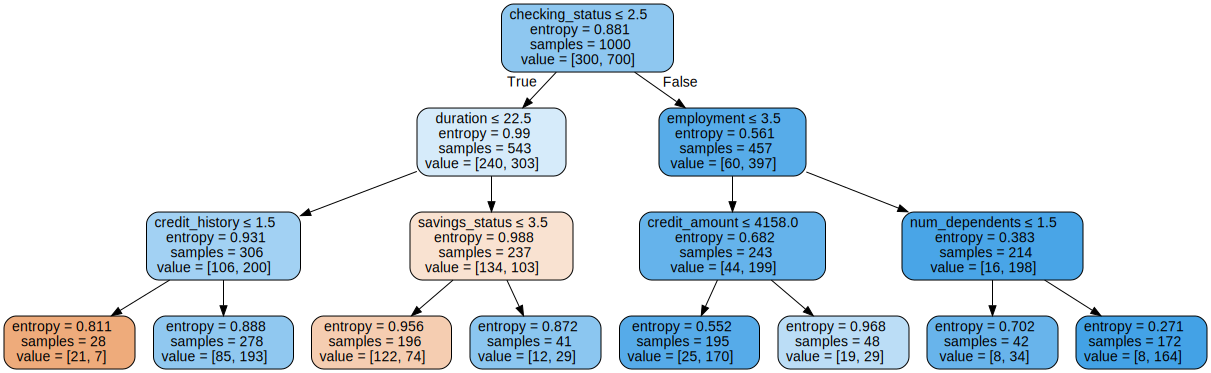

In [35]:
graph

### Build full tree

In [36]:
full = tree.DecisionTreeClassifier(criterion="entropy", random_state=0)
full = full.fit(X, y)
tree_importances = pd.Series(full.feature_importances_, index=X.columns).sort_values(ascending=False)

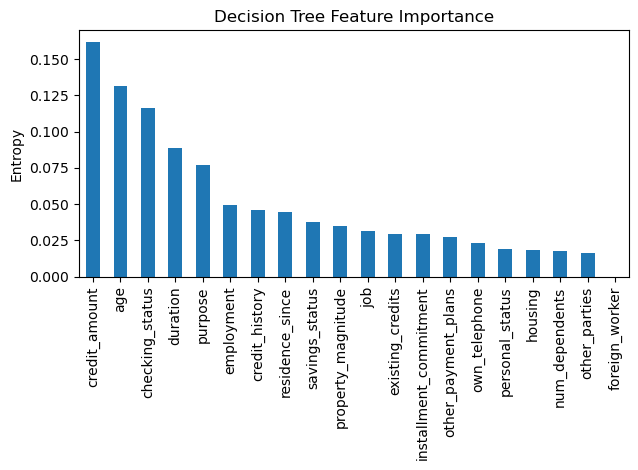

In [37]:
# Decision Tree Feature Importance
fig, ax = plt.subplots()
tree_importances.plot.bar(y=tree_importances.sort_values(ascending=True), ax=ax)
ax.set_title("Decision Tree Feature Importance")
ax.set_ylabel("Entropy")
fig.tight_layout()

#### Baseline

In [38]:
%%time
baseline = cross_val_score(estimator=full,X=X, y=y,
                scoring="roc_auc", cv=2).mean()


print('Embedded --> AUC score with full dataset: %.2f%%' %(baseline*100))

Embedded --> AUC score with full dataset: 59.64%
CPU times: user 33.6 ms, sys: 4.18 ms, total: 37.8 ms
Wall time: 35.3 ms


### Embedded - Decision Tree (Top - 9) 

In [40]:
%%time
top_9 = ['credit_amount', 'age','checking_status', 'duration', 'purpose',
         'employment', 'credit_history','residence_since', 'savings_status']
auc = cross_val_score(estimator=full,X=X.loc[:,top_9], y=y,
                scoring="roc_auc", cv=2).mean()


print('Embedded --> AUC score with top 9 features %.2f%%' %(baseline*100))

Embedded --> AUC score with top 9 features 59.64%
CPU times: user 29.3 ms, sys: 3.8 ms, total: 33.1 ms
Wall time: 30.9 ms


In [39]:
# The higher the score value, the more relevant the feature is.
sorted(zip(X.columns, full.feature_importances_),key=lambda x: x[1], reverse=True)

[('credit_amount', 0.16186472076274894),
 ('age', 0.13167889887773798),
 ('checking_status', 0.11610693128447624),
 ('duration', 0.08895357122023224),
 ('purpose', 0.07709174902783292),
 ('employment', 0.04946743217885981),
 ('credit_history', 0.04575832730098227),
 ('residence_since', 0.04464537414792233),
 ('savings_status', 0.03737722898584035),
 ('property_magnitude', 0.03494689579410262),
 ('job', 0.031628461037759334),
 ('existing_credits', 0.029489450767469616),
 ('installment_commitment', 0.02910106436486632),
 ('other_payment_plans', 0.027488354115250628),
 ('own_telephone', 0.022908131786922827),
 ('personal_status', 0.019291493979370297),
 ('housing', 0.01862595524906185),
 ('num_dependents', 0.01748168040978599),
 ('other_parties', 0.016094278708777433),
 ('foreign_worker', 0.0)]

In [123]:
%%time
# Tree 
top_9 = ['checking_status','duration','credit_amount', 'credit_history',
         'savings_status','age','property_magnitude', 'purpose','installment_commitment'] 
auc = cross_val_score(estimator=full,X=X.loc[:,top_9], y=y,
                scoring="roc_auc", cv=2).mean()

print('Embedded --> AUC score with top 9 features: %.2f%%' %(auc*100))

Embedded --> AUC score with top 9 features: 60.98%
CPU times: user 12.7 ms, sys: 5.89 ms, total: 18.6 ms
Wall time: 17 ms


### Applied to NB

In [131]:
%%time
top_9 = ['credit_amount', 'age','checking_status', 'duration', 'purpose',
         'employment', 'credit_history','residence_since', 'job'] 
auc = cross_val_score(estimator=nb,X=X.loc[:,top_9], y=y,
                scoring="roc_auc", cv=2).mean()

print('Embedded --> AUC score with top 9 features: %.2f%%' %(auc*100))

Embedded --> AUC score with top 9 features: 75.87%
CPU times: user 31.1 ms, sys: 2.52 ms, total: 33.6 ms
Wall time: 30.4 ms


## Hybrid methods
Combine multiple classes of feature selection to find the most relevant features from a dataset.

<center>
<img src="./images/hybrid.png" alt="embedded" width="408" height="527" >
</center>

- Leverages the complementary strenghts of the FS classes.
- Mitigate limitations of FS classes.
- Examples: 
    * Filter + Embedded
    * Wrapper + Embedded

### Hybrid Examples

- Filter + Embedded

In [41]:
%%time
Gini_top_9 = ['checking_status','credit_history','savings_status', 'duration','credit_amount', 
'age','property_magnitude', 'employment', 'other_payment_plans']
auc = cross_val_score(estimator=full,X=X.loc[:,Gini_top_9], y=y,
                scoring="roc_auc", cv=2).mean()
print('Hybrid(Gini + DT) --> AUC score with top 9 features: %.2f%%' %(auc*100))

Hybrid(Gini + DT) --> AUC score with top 9 features: 65.69%
CPU times: user 32.7 ms, sys: 21 µs, total: 32.7 ms
Wall time: 30.9 ms


- Wrapper + Embedded

In [42]:
%%time
sfs1 = SFS(full, 
           k_features=9, forward=True, 
           scoring='roc_auc', cv=2)
sfs1 = sfs1.fit(X, y)
print('Hybrid(Wrapper-AUC + DT) --> AUC score with top 9 features: %.2f%%' % (sfs1.k_score_*100))

Hybrid(Wrapper-AUC + DT) --> AUC score with top 9 features: 63.24%
CPU times: user 812 ms, sys: 6.96 ms, total: 819 ms
Wall time: 816 ms


In [46]:
%%time
baseline = cross_val_score(estimator=tree,X=X, y=y,
                scoring="roc_auc", cv=2).mean()


print('AUC score with full dataset: %.2f%%' %(baseline*100))

AUC score with full dataset: 0.7361
CPU times: user 143 ms, sys: 3.94 ms, total: 147 ms
Wall time: 146 ms


- NB Classifier
|Measure |Baseline| Filter  | Wrapper    | Embedded  
|---:|:-------------|:-------------|:-----------|:------|
| AUC| 72.21%|76.54% |    77.68%    |  75.87%  | 
| Size|    20    |    9    |    9    |   9 | 
| TIme|43.8 ms |34.5 ms |    865 ms   |   30.4 ms| 

- DT Classifier
|Measure |Baseline| Filter-H  | Wrapper-H    | Embedded  
|---:|:-------------|:-------------|:-----------|:------|
| AUC| 59.64%|65.69% |    63.24%  |  59.64%  | 
| Size|    19    |    9    |    9    |   9 | 
| TIme|35.3 ms |30.9 ms |    816 ms    |  30.9 ms| 

## Summary
- Wrapper methods are the most computationally intensive.
- The prefered FS method is model and dataset specific.
- Feature selection does not always improve performance.

## Any Questions/Comments?
<br></br>
<center>   
<img src="./images/person.png" alt="transition" width="512" height="512">
</center>

## Content:
1. Introduction to Feature Selection (FS)
2. **Search strategies**
3. **FS classes**
4. **Evaluation metrics**
    - Mono-objective FS
    - Multi-objective FS
    - Many-objective FS <BR/><BR/>
5. Open challenges
6. Conclusion
7. Libraries

#### Evaluation metrics
- Predictive performance
    - Accuracy
    - Precision
    - Recall
    - Specificity
    - F1 score
    - ROC AUC

- Model fairness
    - Statistical Parity
    - Equalized odds

- Model understanding
    - Number of features

- Feature redundancy
    - Correlation measures
    - Variance inflation factor

In [7]:

# Define the URL for the iframe
url = "https://wall.sli.do/event/73ty2hUXdRrxzig7PtxJ3s?section=52ab903f-d0a7-419c-888e-bce22d55cafd"
# Create the IFrame
iframe = IFrame(url, width=600, height=800)
# Define HTML/CSS to center the iframe
slido3 = """
<div style="display: flex; justify-content: center;">
    {}
</div>
""".format(iframe._repr_html_())

# Join at slido.com 
# #3297 347
<center>   
<img src="./images/slido3.png" alt="transition" width="450" height="250">
</center>

In [8]:
# Display the centered iframe
display(HTML(slido3))

## Mono-objective
<center>
<img src="./images/mono.gif" align="right" alt="mono" width="532" height="284">
</center>


- One best objective score
- Least complexity
- Most commonly used


E.g: Predictive performance, filter measures

### All examples seen so far are mono-objective FS

In [148]:
class credit(BinaryProblem):
    
    def __init__(self, pred: pd.DataFrame, target: pd.Series, classifier, n_var:int=20):
        super(credit, self).__init__()
        self.pred = pred
        self.target = target
        self.classifier = classifier
        self.n_var = n_var
        self.obj_labels = ["auc"]
        
    def number_of_variables(self) -> int:
        return 1
    def number_of_objectives(self) -> int:
        return 1
    def number_of_constraints(self) -> int:
        return 1
        
    def evaluate(self, solution: BinarySolution) -> BinarySolution:
        
        # check constraint and if violated generate a new solution
        self.__evaluate_constraints(solution)
        if solution.constraints[0] == 0:
            check = random.randrange(self.n_var)
            solution.variables[0] = [True if _ == check else False for _ in range(self.n_var)]
       
        auc = cross_val_score(estimator=self.classifier, 
                                   X=self.pred.iloc[:,solution.variables[0]], y=self.target,
                                   scoring="roc_auc", cv=2).mean()
        solution.objectives[0] = auc * -1.0
        return solution
        
    def __evaluate_constraints(self, solution: BinarySolution) -> None:
        solution.constraints = [0 for _ in range(self.number_of_constraints())]
        if sum(solution.variables[0]) == 0:
            solution.constraints[0] = 0
        else:
            solution.constraints[0] = 1
        
    def create_solution(self) -> BinarySolution:
        new_solution = BinarySolution(number_of_variables=self.number_of_variables(),
                                      number_of_objectives=self.number_of_objectives())
        new_solution.variables[0] =  [True if random.randint(0, 1) == 1 else 
                                      False for _ in range(self.n_var)]
        return new_solution
    
    def name(self) -> str:
        return 'Credit'
logging.disable()

#### Mono-objective FS Example
- Predictive performance: AUC (↑)

In [149]:
problem = credit(X, y, nb)
algorithm = GeneticAlgorithm(
        problem=problem,
        population_size=40,
        offspring_population_size=40,
        mutation=BitFlipMutation(1.0 / problem.n_var),
        crossover=SPXCrossover(1.0),
        termination_criterion=StoppingByEvaluations(max_evaluations=20000),
    )

algorithm.run()
result = algorithm.get_result()
indices = [int(i) for i in range(len(result.get_binary_string())) if result.get_binary_string()[i] == "1"]

In [150]:
soln_df = pd.DataFrame(columns=["Solution", "AUC"])
soln_df["Solution"] = [1]
soln_df["AUC"] = [result.objectives[0]*-100]

In [151]:

print(tabulate(soln_df.set_index('Solution').round(2), headers = 'keys', tablefmt = 'psql'))
print('Execution time in seconds: %.2f' %(algorithm.total_computing_time))
print('Number of featurea: %.0f' %len(indices))

+------------+-------+
|   Solution |   AUC |
|------------+-------|
|          1 | 77.75 |
+------------+-------+
Execution time in seconds: 199.63
Number of featurea: 9


## Multi-objective
<center>
<img src="./images/multi.gif" align="right" alt="multi" width="532" height="284">
</center>

- Two or three objectives
- More than one solution
- High complexity



E.g: Predictive performance and redundancy


### Non-dominated Solutions
A non-dominated solution is one in which no one objective can be improved without a simultaneous detriment to at least one of the other objectives.
<center>
<img src="./images/pareto.png" alt="pareto" width="776" height="444">
</center>

### Related Work
<center>   
<img src="./images/wrapper_paper.png" alt="title" width="993" height="235">
</center>

Objectives:
- Accuracy
- AUC

**Result:** Multi-objective FS preserves, balances, and in some cases improves
model performance.

#### Filter VS Wrapper
<center>   
<img src="./images/acc_table-1.png" alt="title" width="2400" height="1600">
</center>

In [152]:
class credit(BinaryProblem):
    
    def __init__(self, pred: pd.DataFrame, target: pd.Series, classifier, n_var:int=20):
        super(credit, self).__init__()
        self.pred = pred
        self.target = target
        self.classifier = classifier
        self.n_var = n_var
        self.obj_labels = ["auc", "size"]
        
    def number_of_variables(self) -> int:
        return 1
    def number_of_objectives(self) -> int:
        return 2
    def number_of_constraints(self) -> int:
        return 1
        
    def evaluate(self, solution: BinarySolution) -> BinarySolution:
        
        # check constraint and if violated generate a new solution
        self.__evaluate_constraints(solution)
        if solution.constraints[0] == 0:
            check = random.randrange(self.n_var)
            solution.variables[0] = [True if _ == check else False for _ in range(self.n_var)]
       
        auc = cross_val_score(estimator=self.classifier, 
                                   X=self.pred.iloc[:,solution.variables[0]], y=self.target,
                                   scoring="roc_auc", cv=2).mean()
        size = sum(solution.variables[0])
        
        solution.objectives[0] = auc * -1.0
        solution.objectives[1] = size
        return solution
        
    def __evaluate_constraints(self, solution: BinarySolution) -> None:
        solution.constraints = [0 for _ in range(self.number_of_constraints())]
        if sum(solution.variables[0]) == 0:
            solution.constraints[0] = 0
        else:
            solution.constraints[0] = 1
        
    def create_solution(self) -> BinarySolution:
        new_solution = BinarySolution(number_of_variables=self.number_of_variables(),
                                      number_of_objectives=self.number_of_objectives())
        new_solution.variables[0] =  [True if random.randint(0, 1) == 1 else 
                                      False for _ in range(self.n_var)]
        return new_solution
    
    def name(self) -> str:
        return 'Credit'
logging.disable()

#### Multi-objective FS Example
- Predictive performance: AUC (↑)
- Model understanding: Number of features (↓)

In [153]:

problem = credit(X, y, nb)
algorithm = NSGAII(
        problem=problem,
        population_size=40,
        offspring_population_size=40,
        mutation=BitFlipMutation(1.0 / problem.n_var),
        crossover=SPXCrossover(1.0),
        termination_criterion=StoppingByEvaluations(max_evaluations=20000),
    )

algorithm.run()
solutions = get_non_dominated_solutions(algorithm.get_result())

In [154]:
soln_df = pd.DataFrame(columns=["Solution", "#Features", "AUC"])
soln_df["Solution"] = [i for i in range(1, len(solutions)+1)]
soln_df["#Features"] = [solution.objectives[1] for solution in solutions]
soln_df["AUC"] = [solution.objectives[0]*-100 for solution in solutions]

In [155]:

print(tabulate(soln_df.set_index('Solution').round(2), headers = 'keys', tablefmt = 'psql'))
print('Execution time in seconds: %.4f' %(algorithm.total_computing_time))

+------------+-------------+-------+
|   Solution |   #Features |   AUC |
|------------+-------------+-------|
|          1 |           1 | 70.98 |
|          2 |           9 | 77.75 |
|          3 |           2 | 74.87 |
|          4 |           3 | 76.34 |
|          5 |           4 | 77.15 |
|          6 |           5 | 77.45 |
|          7 |           6 | 77.61 |
|          8 |           7 | 77.73 |
|          9 |           8 | 77.75 |
+------------+-------------+-------+
Execution time in seconds: 187.2803


## Many-objective
<center>
<img src="./images/many.gif" align="right" alt="many" width="532" height="284">
</center>

- Four or more objectives
- More than one solution
- Most complex
- Reflect real world scenarios



E.g: Predictive performance, redundancy, complexity, and fairness


#### Many-objective FS Example
- Predictive performance: AUC (↑)
- Model understanding: Number of features (↓)
- Feature redundancy: Variance inflation factor (↓)
- Model Fairness: Statistical parity (↑)

In [18]:

class credit(BinaryProblem):
    
    def __init__(self, pred: pd.DataFrame, target: pd.Series, clf, sf, n_var:int=20):
        super(credit, self).__init__()
        self.pred = pred
        self.target = target
        self.classifier = clf
        self.n_var = n_var
        self.sf = sf
        self.obj_labels = ["auc", "size", "vif", "sp"]
        
    def number_of_variables(self) -> int:
        return 1
    def number_of_objectives(self) -> int:
        return 4
    def number_of_constraints(self) -> int:
        return 1
        
    def evaluate(self, solution: BinarySolution) -> BinarySolution:
        
        # check constraint and if violated generate a new solution
        self.__evaluate_constraints(solution)
        if solution.constraints[0] == 0:
            check = random.randrange(self.n_var)
            solution.variables[0] = [True if _ == check else False for _ in range(self.n_var)]
       
        auc = cross_val_score(estimator=self.classifier, 
                                   X=self.pred.iloc[:,solution.variables[0]], y=self.target,
                                   scoring="roc_auc", cv=2).mean()
        size = sum(solution.variables[0])
        
        if len(self.pred.iloc[:,solution.variables[0]].columns) < 2:
            vif_score = 0
        else:
            vif_data = pd.DataFrame()
            vif_data["feature"] = self.pred.iloc[:,solution.variables[0]].columns
            # calculating VIF for each feature
            vif_data["VIF"] = [vif(self.pred.iloc[:,solution.variables[0]].values, i) 
                               for i in range(len(self.pred.iloc[:,solution.variables[0]].columns))]
            vif_score = vif_data["VIF"].mean()
        y_pred = cross_val_predict(self.classifier, 
                                   self.pred.iloc[:,solution.variables[0]], 
                                   self.target, cv=2)
        dp = demographic_parity_ratio(self.target, y_pred, sensitive_features=self.pred[self.sf])
        
        solution.objectives[0] = auc * -1.0
        solution.objectives[1] = size
        solution.objectives[2] = vif_score
        solution.objectives[3] = dp * -1.0
        return solution
        
    def __evaluate_constraints(self, solution: BinarySolution) -> None:
        solution.constraints = [0 for _ in range(self.number_of_constraints())]
        if sum(solution.variables[0]) == 0:
            solution.constraints[0] = 0
        else:
            solution.constraints[0] = 1
        
    def create_solution(self) -> BinarySolution:
        new_solution = BinarySolution(number_of_variables=self.number_of_variables(),
                                      number_of_objectives=self.number_of_objectives())
        new_solution.variables[0] =  [True if random.randint(0, 1) == 1 else 
                                      False for _ in range(self.n_var)]
        return new_solution
    
    def name(self) -> str:
        return 'Credit'
logging.disable()

In [19]:

problem = credit(X, y, nb, 'personal_status')
algorithm = NSGAIII(problem=problem,
                   population_size=40,
                   reference_directions=UniformReferenceDirectionFactory(4, n_points=39),
                   mutation=BitFlipMutation(1.0 / problem.n_var),
                   crossover=SPXCrossover(1.0),
                   termination_criterion=StoppingByEvaluations(max_evaluations=20000))

algorithm.run()
solutions = get_non_dominated_solutions(algorithm.get_result())

In [21]:
soln_df = pd.DataFrame(columns=["Solution", "#Features", "AUC", "VIF", "SP"])
soln_df["Solution"] = [i for i in range(1, len(solutions)+1)]
soln_df["#Features"] = [solution.objectives[1] for solution in solutions]
soln_df["AUC"] = [solution.objectives[0]*-100 for solution in solutions]
soln_df["VIF"] = [solution.objectives[2] for solution in solutions]
soln_df["SP"] = [solution.objectives[3]*-1 for solution in solutions]

In [22]:

print(tabulate(soln_df.set_index('Solution').round(2), headers = 'keys', tablefmt = 'psql'))
print('Execution time in seconds: %.4f' %(algorithm.total_computing_time))

+------------+-------------+-------+-------+------+
|   Solution |   #Features |   AUC |   VIF |   SP |
|------------+-------------+-------+-------+------|
|          1 |           4 | 77.15 |  0.06 | 0.84 |
|          2 |           2 | 73.4  |  0.01 | 0.92 |
|          3 |           8 | 76.35 |  5.71 | 0.98 |
|          4 |           4 | 76.78 |  0.05 | 0.56 |
|          5 |           3 | 75.51 |  3.39 | 0.83 |
|          6 |           1 | 70.98 |  0    | 0.94 |
|          7 |           4 | 74.52 |  0.04 | 0.92 |
|          8 |           5 | 74.43 |  0.07 | 0.98 |
|          9 |           9 | 76.48 |  0.13 | 0.98 |
|         10 |           3 | 73.74 |  0.01 | 0.79 |
|         11 |           4 | 74.61 |  4.77 | 0.95 |
|         12 |           4 | 71.12 |  0.09 | 0.99 |
|         13 |           1 | 59.67 |  0    | 1    |
|         14 |           3 | 62.16 |  0.02 | 1    |
|         15 |           4 | 73.44 |  3.23 | 0.93 |
|         16 |           6 | 77.02 |  0.06 | 0.91 |
|         17

In [46]:

# Define the URL for the iframe
url = "https://lookerstudio.google.com/embed/reporting/8ead3504-246d-4d61-b23b-1eaeba6b02fc/page/B53hD"
# Create the IFrame
iframe = IFrame(url, width=1200, height=900)
# Define HTML/CSS to center the iframe
dashboard = """
<div style="display: flex; justify-content: center;">
    {}
</div>
""".format(iframe._repr_html_())

In [47]:
# Display results in dashboard
display(HTML(dashboard))

In [32]:
for solution in solutions:
    indices = [int(i) for i in range(len(solution.get_binary_string())) if solution.get_binary_string()[i] == "1"]
    print(list(X.columns[indices]))

['checking_status', 'duration', 'credit_history', 'employment']
['checking_status', 'property_magnitude']
['checking_status', 'credit_history', 'purpose', 'credit_amount', 'savings_status', 'employment', 'installment_commitment', 'other_payment_plans']
['checking_status', 'duration', 'credit_history', 'personal_status']
['checking_status', 'credit_history', 'credit_amount']
['checking_status']
['checking_status', 'employment', 'installment_commitment', 'property_magnitude']
['checking_status', 'duration', 'purpose', 'employment', 'other_payment_plans']
['checking_status', 'duration', 'credit_history', 'savings_status', 'employment', 'installment_commitment', 'residence_since', 'other_payment_plans', 'job']
['checking_status', 'savings_status', 'property_magnitude']
['checking_status', 'credit_amount', 'employment', 'installment_commitment']
['checking_status', 'residence_since', 'other_payment_plans', 'existing_credits']
['savings_status']
['savings_status', 'installment_commitment', '

In [28]:
selected

[False, False, False, False]

## No feature selection?
<br></br>
<center>   
<img src="./images/person.png" alt="transition" width="512" height="512">
</center>

In [51]:
start_time = time.time()
baseline = cross_val_score(estimator=nb,X=X, y=y,
                scoring="roc_auc", cv=2).mean()
end_time = time.time()

print('AUC score with full dataset: %.4f' %baseline)
print('Execution time in seconds: %.4f' %(end_time-start_time))

AUC score with full dataset: 0.5914
Execution time in seconds: 0.0796


## Summary
- Mono-objective FS is the most commonly used.
- Multi- and Many-objective FS mirror real world needs more accurately.
- It comes at a high computational cost.

|Measure | Baseline |Mono-obj FS  | Multi-obj FS    | Many-obj FS  
|---:|-------------|:-------------|:-----------|:------|
| AUC|72.21%| 77.75 % |   77.75 %   |  77.15%  | 
| Size| 20|9 |    8    |   4 | 
| Time |43.8 ms| 200 secs  | 187 secs    |  896 secs  | 

## Content:
1. Introduction to Feature Selection (FS)
2. **Search strategies**
3. **FS classes**
4. **Evaluation metrics**
5. Open challenges
6. Conclusion
7. Libraries

## Open Challenges

- Efficiency of FS methods for
    * High-dimensional data
    * Large number of instances

- Scalability of FS methods considering
    * Parallelism
    * Distribution

- Adequacy of FS methods in dealing with:
    * Unbalanced classification
    * Multi-label classification

- Many-objective FS
    * Interpretability of MOFS results
    * Visualization of multiple solutions

In [ ]:
### Dashboard of the results

## Conclusion
- Feature selection is an essential step in the ML pipeline.
- It can improve performance and consequently model understanding.
- The benefits of using FS for different ML models vary.
- There are many open challenges, expecially in the context of big data.

## Libraries: 
- SkFeature
    - Filter
    - Sequential (wrapper)
- MLXtend
    - Exhaustive
    - Sequential (wrapper)
- JmetalPy
    - Heuristics based
- SKLearn
    - Filter
    - Embeded
    - Sequential (wrapper)

## Notebook on GitHub

<center>   
<img src="./images/qr-code.png" alt="transition" width="450" height="250">
</center>

### URL: https://github.com/F-U-Njoku/fs_tutorial

## Any Questions/Comments?
<br></br>
<center>   
<img src="./images/person.png" alt="transition" width="512" height="512">
</center>

In [132]:
#!pip install openml
#!pip install mlxtend
#!pip install fairlearn
#!pip install jmetalpy
#!pip install git+https://github.com/jundongl/scikit-feature
#!pip install nbconvert
#!pip install pyppeteer

  Cloning https://github.com/jundongl/scikit-feature to /tmp/pip-req-build-0wjc_dx9
  Running command git clone --filter=blob:none --quiet https://github.com/jundongl/scikit-feature /tmp/pip-req-build-0wjc_dx9
  Resolved https://github.com/jundongl/scikit-feature to commit 48cffad4e88ff4b9d2f1c7baffb314d1b3303792
  Preparing metadata (setup.py) ... done
  Created wheel for skfeature: filename=skfeature-1.0.0-py3-none-any.whl size=61488 sha256=74e3c02fe33e8636f1d142c59f1768744ac14e9c6b1485e029c064886919c3a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-z3xu7ziy/wheels/8f/62/16/dbf7334329e32e3674041b336ac91a5258f33ab10be507697c
Successfully built skfeature


In [1]:

path = Path.home() / ".jupyter" / "nbconfig"
cm = BaseJSONConfigManager(config_dir=str(path))
tmp = cm.update(
        "rise",
        {
            "theme": "serif",
            "transition": "fade",
            "start_slideshow_at": "selected",
            "autolaunch": True,
            "width": "100%",
            "height": "100%",
            "header": "",
            "footer":"Finding Relevant Information in Big Datasets with ML",
            "scroll": True,
            "enable_chalkboard": True,
            "slideNumber": True,
            "center": False,
            "controlsLayout": "edges",
            "slideNumber": True,
            "hash": True,
        }
    )
